In [1]:
import pandas as pd
import numpy as np
from os.path import join
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from ete3 import NCBITaxa
import random
random.seed(10)
import torch
import esm
from bioservices import *
from data_preprocessing import *
from functions_and_dicts_data_preprocessing_GNN import *
from build_GNN import *
import warnings
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
warnings.filterwarnings('ignore')
datasets_dir = "../../data"

CURRENT_DIR = os.getcwd()

c:\Users\marle\anaconda3\envs\py37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Loading in Sabio data

#### Loading Sabio data

In [3]:
organism = "Seed plants"

df_Sabio = pd.read_table(join(datasets_dir, "kcat_model_" + organism + ".tsv"))

df_Sabio["kcat"] = df_Sabio["kcat"].astype('float')
df_Sabio["PMID"] = df_Sabio["PMID"].astype('Int64')

df_Sabio["substrate_IDs"] = df_Sabio["substrate_IDs"].str.split('#')
df_Sabio["product_IDs"] = df_Sabio["product_IDs"].str.split('#')

df_Sabio["Type"][df_Sabio['Type'].str.contains("wildtype")] = "wildtype"
df_Sabio["Type"][df_Sabio['Type'].str.contains("mutant")] = "mutant"

print("Number of data points: %s" % len(df_Sabio))
print("Number of UniProt IDs: %s" % len(set(df_Sabio["Uniprot IDs"])))

df_kcat = df_Sabio

Number of data points: 1660
Number of UniProt IDs: 413


#### Removing duplicates

In [ ]:
droplist = []

for ind in df_kcat.index:
    UID, kcat = df_kcat["Uniprot IDs"][ind], df_kcat["kcat"][ind]
    help_df = df_kcat.loc[df_kcat["Uniprot IDs"] == UID].loc[df_kcat["kcat"] == kcat]
    
    if len(help_df) > 1:
        droplist = droplist + list(help_df.index)[1:]
        

In [ ]:
df_kcat.drop(list(set(droplist)), inplace = True)
print("Dropping %s data points, because they are duplicated." % len(set(droplist)))
df_kcat.reset_index(inplace = True, drop = True)
df_kcat

#### Removing top and bottom 3% of kcat values

In [ ]:
def find_outliers_IQR(df):

   q1=df.quantile(0.25)

   q3=df.quantile(0.75)

   IQR=q3-q1

   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

   return outliers

find_outliers_IQR(df_kcat["kcat"])

print(df_kcat['kcat'].quantile(0.03),  df_kcat['kcat'].quantile(0.97))

In [ ]:
df_kcat = df_kcat[(df_kcat['kcat'] > df_kcat['kcat'].quantile(0.03)) & (df_kcat['kcat'] < df_kcat['kcat'].quantile(0.97))]
df_kcat.reset_index(inplace = True, drop = True)

In [ ]:
todrop= []

for ind in df_kcat.index:
    UID = df_kcat["Uniprot IDs"][ind]
    if len(UID.split(';')) > 1:
        todrop.append(ind)
        print(df_kcat["Uniprot IDs"][ind])
        print(todrop)
        
df_kcat.drop(todrop, inplace=True)
df_kcat.reset_index(inplace = True, drop = True)

In [ ]:
df_kcat["substrate_IDs"] = df_kcat["substrate_IDs"].apply(lambda x: (set(x)))
df_kcat["product_IDs"] = df_kcat["product_IDs"].apply(lambda x: (set(x)))

In [ ]:
df_kcat.to_pickle(join(datasets_dir, "kcat_data_merged.pkl"))

## 2. Assigning IDs to every unique sequence and to every unique reaction in the dataset

#### Creating DataFrames for all sequences and for all reactions

In [ ]:
df_reactions = pd.DataFrame({"substrates": df_kcat["substrate_IDs"],
                            "products" : df_kcat["product_IDs"]})

df_reactions = df_reactions.loc[df_reactions["substrates"] != set([])]
df_reactions = df_reactions.loc[df_reactions["products"] != set([])]


droplist = []
for ind in df_reactions.index:
    sub_IDs, pro_IDs = df_reactions["substrates"][ind], df_reactions["products"][ind]
    help_df = df_reactions.loc[df_reactions["substrates"] == sub_IDs].loc[df_reactions["products"] == pro_IDs]
    if len(help_df):
        for ind in list(help_df.index)[1:]:
            droplist.append(ind)
            
df_reactions.drop(list(set(droplist)), inplace = True)
df_reactions.reset_index(inplace = True, drop =True)

df_reactions["Reaction ID"] = ["Reaction_" + str(ind) for ind in df_reactions.index]

In [ ]:
df_sequences = pd.DataFrame(data = {"Sequence" : df_kcat["Sequence"].unique()})
df_sequences = df_sequences.loc[~pd.isnull(df_sequences["Sequence"])]
df_sequences.reset_index(inplace = True, drop = True)
df_sequences["Sequence ID"] = ["Sequence_" + str(ind) for ind in df_sequences.index]

df_sequences

#### Calculating maximal kcat value for each reaction and sequence

In [ ]:
df_reactions["max_kcat_for_RID"] = np.nan
for ind in df_reactions.index:
    df_reactions["max_kcat_for_RID"][ind] = max(df_kcat.loc[df_kcat["substrate_IDs"] == df_reactions["substrates"][ind]].loc[df_kcat["product_IDs"] == df_reactions["products"][ind]]["kcat"])

In [ ]:
df_sequences["max_kcat_for_UID"] = np.nan
for ind in df_sequences.index:
    df_sequences["max_kcat_for_UID"][ind] = max(df_kcat.loc[df_kcat["Sequence"] == df_sequences['Sequence'][ind]]["kcat"])

#### Calculating the sum of the molecular weights of all substrates and of all products

In [ ]:
df_reactions["MW_frac"] = np.nan

for ind in df_reactions.index:
    substrates = list(df_reactions["substrates"][ind])
    products = list(df_reactions["products"][ind])
    
    mw_subs = mw_mets(metabolites = substrates)
    mw_pros = mw_mets(metabolites = products)
    
    if mw_subs == np.nan or mw_pros == np.nan:
        df_reactions["MW_frac"][ind] = np.inf
    if mw_pros != 0:
        df_reactions["MW_frac"][ind] = mw_subs/mw_pros
    else:
        df_reactions["MW_frac"][ind] = np.inf
        
df_reactions

#### Calculating enzyme, reaction and substrate features

In [ ]:
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm2_t33_650M_UR50D")

In [ ]:
#creating model input:
df_sequences["model_input"] = [seq[:1022] for seq in df_sequences["Sequence"]]
model_input = [(df_sequences["Sequence ID"][ind], df_sequences["model_input"][ind]) for ind in df_sequences.index]
seqs = [model_input[i][1] for i in range(len(model_input))]
#loading ESM-2 model:
print(".....2(a) Loading ESM-2 model.")
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
#convert input into batches:

#Calculate ESM-2 representations
print(".....2(b) Calculating enzyme representations.")
df_sequences["Enzyme rep"] = ""

for ind in df_sequences.index:
    batch_labels, batch_strs, batch_tokens = batch_converter([(df_sequences["Sequence ID"][ind], df_sequences["model_input"][ind])])
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33])
    df_sequences["Enzyme rep"][ind] = results["representations"][33][0, 1 : len(df_sequences["model_input"][ind]) + 1].mean(0).numpy()
    
df_sequences.head(5)

In [ ]:
def get_metabolite_type(met):
    if is_KEGG_ID(met):
        return("KEGG")
    elif is_InChI(met):
        return("InChI")
    else:
        return("invalid")

def get_reaction_site_smarts(metabolites):
    reaction_site = ""
    for met in metabolites:
        met_type = get_metabolite_type(met)
        if met_type == "KEGG":
            try:
                Smarts = Chem.MolToSmarts(Chem.MolFromMolFile(join(CURRENT_DIR, "data", "mol-files",  met + ".mol")))
            except OSError:
                return(np.nan)
        elif met_type == "InChI":
            Smarts = Chem.MolToSmarts(Chem.inchi.MolFromInchi(met))
        else:
            Smarts = "invalid"
        reaction_site = reaction_site + "." + Smarts
    return(reaction_site[1:])


def is_KEGG_ID(met):
    #a valid KEGG ID starts with a "C" or "D" followed by a 5 digit number:
    if len(met) == 6 and met[0] in ["C", "D"]:
        try:
            int(met[1:])
            return(True)
        except: 
            pass
    return(False)

def is_InChI(met):
    m = Chem.inchi.MolFromInchi(met,sanitize=False)
    if m is None:
      return(False)
    else:
      try:
        Chem.SanitizeMol(m)
      except:
        print('.......Metabolite string "%s" is in InChI format but has invalid chemistry' % met)
        return(False)
    return(True)

def convert_fp_to_array(difference_fp_dict):
    fp = np.zeros(2048)
    for key in difference_fp_dict.keys():
        fp[key] = difference_fp_dict[key]
    return(fp)

In [ ]:
df_reactions["difference_fp"], df_reactions["structural_fp"],  = "", ""
#each metabolite should be either a KEGG ID, InChI string, or a SMILES:
for ind in df_reactions.index:
    left_site = get_reaction_site_smarts(df_reactions["substrates"][ind])
    right_site = get_reaction_site_smarts(df_reactions["products"][ind])
    if not pd.isnull(left_site) and not pd.isnull(right_site):
        rxn_forward = AllChem.ReactionFromSmarts(left_site + ">>" + right_site)
        difference_fp = Chem.rdChemReactions.CreateDifferenceFingerprintForReaction(rxn_forward)
        difference_fp = convert_fp_to_array(difference_fp.GetNonzeroElements())
        df_reactions["difference_fp"][ind] = difference_fp
        df_reactions["structural_fp"][ind] = Chem.rdChemReactions.CreateStructuralFingerprintForReaction(rxn_forward).ToBitString()

df_reactions.head(5)

In [ ]:
df_sequences.to_pickle(join(datasets_dir, "all_sequences_with_IDs.pkl"))
df_reactions.to_pickle(join(datasets_dir, "all_reactions_with_IDs.pkl"))

#### Mapping Sequence and Reaction IDs to kcat_df

In [ ]:
df_kcat = df_kcat.merge(df_sequences, on = "Sequence", how = "left")

In [ ]:
df_reactions.rename(columns = {"substrates" : "substrate_IDs",
                              "products" : "product_IDs"}, inplace = True)

df_kcat["Reaction ID"] = np.nan
df_kcat["MW_frac"] = np.nan
df_kcat["max_kcat_for_RID"] = np.nan
df_kcat["difference_fp"] = ""
df_kcat["structural_fp"] = ""

for ind in df_kcat.index:
    sub_set, pro_set = df_kcat["substrate_IDs"][ind], df_kcat["product_IDs"][ind]
    
    help_df = df_reactions.loc[df_reactions["substrate_IDs"] == sub_set].loc[df_reactions["product_IDs"] == pro_set]
    if len(help_df) == 1:
        df_kcat["Reaction ID"][ind] = list(help_df["Reaction ID"])[0]
        df_kcat["max_kcat_for_RID"][ind] = list(help_df["max_kcat_for_RID"])[0]
        df_kcat["MW_frac"][ind] = list(help_df["MW_frac"])[0]
        df_kcat["difference_fp"][ind] = list(help_df["difference_fp"])[0]
        df_kcat["structural_fp"][ind] = list(help_df["structural_fp"])[0]
df_kcat.head(2)

In [ ]:
df_kcat["MACCS FP"] = ""

for ind in df_kcat.index:
    substrate = df_kcat["Main substrate"][ind]
    try:
        id = df_kcat['Substrate_IDs'][ind][df_kcat["Substrates"][ind].split(';').index(substrate)]
    except:
        for i,s in enumerate(df_kcat["Substrates"][ind].split(';')[:-1]):
            if substrate in s or s in substrate:
                id = list(df_kcat['Substrate_IDs'][ind])[i]
    if id[0] == "C":
        try:
            mol = Chem.MolFromMolFile(join(datasets_dir,"mol-files", id + '.mol'))
        except OSError:
            None
    else:
        try:
            mol = Chem.inchi.MolFromInchi(id,sanitize=False)
        except OSError:
            None
    if mol is not None:
        maccs_fp = MACCSkeys.GenMACCSKeys(mol).ToBitString()
        df_kcat["MACCS FP"][ind] = maccs_fp

#### Calculating the maximal kcat value for every EC number in the dataset

In [ ]:
df_EC_kcat = pd.read_csv(join(datasets_dir, "max_EC_" + organism + ".tsv"), sep = "\t", header=0)
# df_EC_kcat = df_EC_kcat.rename(columns={0: "EC", 1: "max_kcat"})

for ind in df_EC_kcat.index:
    try:
        kcat_max = df_EC_kcat[df_EC_kcat["EC"] == df_kcat["ECs"]]["max_kcat"]
        df_EC_kcat["max_kcat"][ind] = kcat_max
        print(ind, kcat_max)
    except:
        pass
        
df_EC_kcat.describe()

In [ ]:
df_EC_kcat = pd.read_csv(join(datasets_dir, "max_EC_" + organism + ".tsv"), sep = "\t", header=0)

df_EC_kcat.head(5)
df_kcat["max_kcat_for_EC"] = np.nan

for ind in df_kcat.index:
    EC = df_kcat["ECs"][ind]
    max_kcat = 0
    try:
        print(EC)
        max_kcat = df_EC_kcat.loc[df_EC_kcat["EC"] == EC, "max_kcat"].iloc[0]
        print(max_kcat)
    except:
        pass
    if max_kcat != 0:
        df_kcat["max_kcat_for_EC"][ind] = max_kcat
df_kcat.to_pickle(join(datasets_dir, "merged_and_grouped_kcat_dataset.pkl"))     

## 3. Removing outliers

#### Removing non-optimally measured values

To ignore $kcat$ values that were obtained under non-optimal conditions, we exclude values lower than 0.1\% than the maximal $kcat$ value for the same enzyme, reaction or EC number.

In [33]:
df_kcat["frac_of_max_UID"] = np.nan
df_kcat["frac_of_max_RID"] = np.nan
df_kcat["frac_of_max_EC"] = np.nan

for ind in df_kcat.index:
    df_kcat["frac_of_max_UID"][ind] =  df_kcat["kcat"][ind]/df_kcat["max_kcat_for_UID"][ind]
    df_kcat["frac_of_max_RID"][ind] =  df_kcat["kcat"][ind]/df_kcat["max_kcat_for_RID"][ind]
    df_kcat["frac_of_max_EC"][ind] = df_kcat["kcat"][ind]/df_kcat["max_kcat_for_EC"][ind]

len(df_kcat)

1328

In [34]:
n = len(df_kcat)

df_kcat = df_kcat.loc[df_kcat["frac_of_max_UID"] >= 0.01]
df_kcat = df_kcat.loc[df_kcat["frac_of_max_RID"] >= 0.01]

df_kcat["frac_of_max_EC"].loc[pd.isnull(df_kcat["frac_of_max_EC"])] = 1
df_kcat = df_kcat.loc[df_kcat["frac_of_max_EC"] <= 10]
df_kcat = df_kcat.loc[df_kcat["frac_of_max_EC"] >= 0.01]

In [35]:
print("We remove %s data points, because we suspect that these kcat values were not measure for the natural reaction " \
    "of an enzyme or under non-optimal conditions." % (n-len(df_kcat)))

We remove 271 data points, because we suspect that these kcat values were not measure for the natural reaction of an enzyme or under non-optimal conditions.


#### Removing data points with reaction queations with uneven fraction of molecular weights

In [36]:
n = len(df_kcat)

df_kcat = df_kcat.loc[df_kcat["MW_frac"] < 3]
df_kcat = df_kcat.loc[df_kcat["MW_frac"] > 1/3]

print("We remove %s data points because the sum of molecular weights of substrates does not match the sum of molecular" \
      "weights of the products." % (n-len(df_kcat)))

We remove 38 data points because the sum of molecular weights of substrates does not match the sum of molecularweights of the products.


In [37]:
print("Size of final kcat dataset: %s" % len(df_kcat))
df_kcat.to_pickle(join(datasets_dir, "final_kcat_dataset_" + organism + ".pkl"))

Size of final kcat dataset: 1019


## 4. Preparing dataset and splitting into train-test

In [4]:
df_kcat = pd.read_pickle(join(datasets_dir, "final_kcat_dataset_" + organism + ".pkl"))

In [128]:
import plotnine
from plotnine import ggplot, geom_point, aes, theme_matplotlib, theme_set, geom_bin_2d
# df_kcat['Temperature'] = df_kcat['Temperature'].replace('-', np.nan)
# df_kcat['pH'] = df_kcat['pH'].replace('-', np.nan)
# df_kcat['pH'] = df_kcat['pH'].astype('float')
# df_kcat['Temperature'] = df_kcat['Temperature'].astype('float')
# df_kcat["log10_kcat"] = np.log10(df_kcat["kcat"])
theme_set(theme_matplotlib())
(
    ggplot(df_kcat) +
    aes(x="Temperature",y="kcat") +
    geom_bin_2d()
)

ImportError: cannot import name 'geom_bin_2d' from 'plotnine' (c:\Users\marle\anaconda3\envs\py37\lib\site-packages\plotnine\__init__.py)

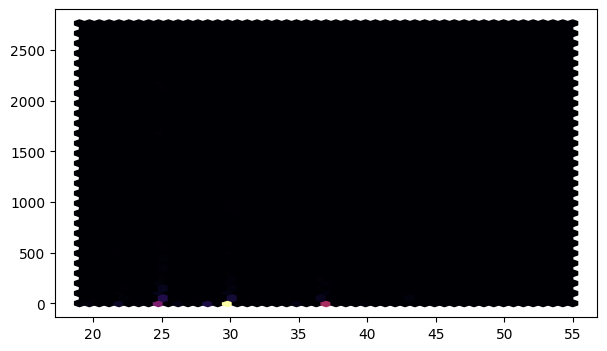

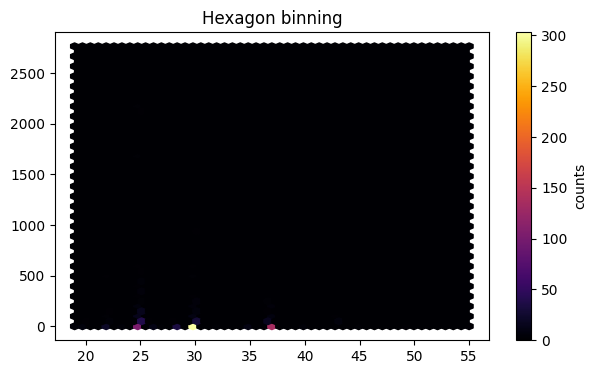

In [117]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4))
hb = ax.hexbin(df_kcat["Temperature"], df_kcat["kcat"], gridsize=50, cmap='inferno')


# ax.set_xlim(x.min(), x.max())
# ax.set_ylim(y.min(), y.max())

# Add a title and colorbar
ax.set_title("Hexagon binning")
fig.colorbar(hb, ax=ax, label='counts')

plt.show()

#### Making input for GNN

In [29]:
# for ind in df_kcat.index:
#     substrate = df_kcat["Main Substrate"][ind]
#     try:
#         id = list(df_kcat['substrate_IDs'][ind])[df_kcat["Substrates"][ind].split(';').index(substrate)]
#     except:
#         for i,s in enumerate(df_kcat["Substrates"][ind].split(';')[:-1]):
#             if substrate in s or s in substrate:
#                 id = list(df_kcat['substrate_IDs'][ind])[i]
#     df_kcat["Main Substrate"][ind] = id

# df_kcat.to_pickle(join(datasets_dir, "final_kcat_dataset_" + organism + ".pkl"))

inchi_ids = {}
for i, element in enumerate(df_kcat["Main Substrate"]):
    if element[0] != 'C' and element not in inchi_ids.keys():
        inchi_ids[element] = str(i)
        mol = Chem.inchi.MolFromInchi(element)
        if not mol is None:
            calculate_atom_and_bond_feature_vectors(mol, str(i))
        Chem.rdmolfiles.MolToMolFile(Chem.inchi.MolFromInchi(element), join(datasets_dir,"mol-files", str(i) + ".mol")  )  

#### Splitting glucosinolates into validation dataset

Search UniProt for GO term related to glucosionalte metabolic process, download file as .tsv and filter dataset

In [5]:
glucosinolates = pd.read_table(join(datasets_dir,"glucosinolates.tsv"))["Entry"].tolist()
df_validation = df_kcat[df_kcat["Uniprot IDs"].isin(glucosinolates)]
df_validation.reset_index(inplace=True, drop = True)
df_kcat = df_kcat[~df_kcat["Uniprot IDs"].isin(glucosinolates)]
df_kcat.reset_index(inplace=True, drop = True)
split = "full"

If training-testing with only Arabidopsis data:

In [16]:
# df_kcat = df_kcat[df_kcat["Organism"] == 'Arabidopsis thaliana']
# df_kcat.reset_index(inplace=True, drop = True)
# split = "Arabidopsis"

If training-testing with only Brassicaceae data:

In [6]:
ncbi = NCBITaxa()

organisms = {}

def is_brassicaceae(org):
    try:
        tax_id = ncbi.get_name_translator([org])[org][0]
        lineage = ncbi.get_lineage(tax_id)
        if 3700 not in lineage:
            return(False)
        else:
            return(True)
    except KeyError:
        return(False)
    
for org in df_kcat["Organism"].tolist():
    if org not in organisms.keys():
        organisms[org] = is_brassicaceae(org)

df_kcat = df_kcat[df_kcat["Organism"].isin([key for key, value in organisms.items() if value is True])]
df_kcat.reset_index(inplace=True, drop = True)
split = "Brassicaceae"

If training-testing only with wildtype data:

In [31]:
df_kcat = df_kcat[df_kcat["Type"].str.contains("wildtype")]
df_kcat.reset_index(inplace=True, drop = True)
split = "wildtype"

If training-testing only with secondary metabolite data:

In [72]:
secondary = pd.read_table(join(datasets_dir,"secondary_metabolites.tsv"))["Entry"].tolist()
df_kcat = df_kcat[df_kcat["Uniprot IDs"].isin(secondary)]
df_kcat.reset_index(inplace=True, drop = True)
split = "secondary"

In [73]:
os.mkdir(join(datasets_dir, "splits", split))

#### Calculating arithmetic mean for kcat values of same enzyme-reaction-substrate combination-pH-temperature

In [ ]:
# df_new = pd.DataFrame(data = {"Reaction ID" : df_kcat["Reaction ID"],
#                                   "Sequence ID" : df_kcat["Sequence ID"],
#                                   "Temperature" : df_kcat["Temperature"],
#                                     "pH" : df_kcat["pH"],
#                                  "Type": df_kcat["Type"],
#                              "MACCS FP" : df_kcat["MACCS FP"]})

# df_new.drop_duplicates(inplace = True)
# df_new.reset_index(inplace = True, drop = True)

# df_new["kcat_values"], df_new["Uniprot IDs"], df_new["ECs"], df_new["Substrates"], df_new["Products"], df_new["ESM2"], df_new["Sequence"], df_new["difference_fp"], df_new["structural_fp"] = "", "", "", "", "", "", "", "", ""

# for ind in df_new.index:
#     RID, SID, Temp, pH, Type, MSubstrate = df_new["Reaction ID"][ind], df_new["Sequence ID"][ind], df_new["Temperature"][ind], df_new["pH"][ind], df_new["Type"][ind], df_new["MACCS FP"][ind]
#     help_df = df_kcat.loc[df_kcat["Reaction ID"] 
#                                  == RID].loc[df_kcat["Sequence ID"] 
#                                              == SID].loc[df_kcat["Temperature"] 
#                                                          == Temp].loc[df_kcat["pH"] 
#                                                                       == pH].loc[df_kcat["Type"] 
#                                                                                  == Type].loc[df_kcat["MACCS FP"] 
#                                                                                               == MSubstrate]
#     print(help_df)
#     df_new["ECs"][ind] = list(help_df["ECs"])
#     df_new["kcat_values"][ind] = list(help_df["kcat"])
#     df_new["Uniprot IDs"][ind] = list(help_df["Uniprot IDs"])
#     df_new["Sequence"][ind] = help_df["Sequence"].values[0]
#     df_new["ESM2"][ind] = help_df["Enzyme rep"].values[0]
#     df_new["difference_fp"][ind], df_new["structural_fp"][ind] = help_df["difference_fp"].values[0], help_df["structural_fp"].values[0]
#     df_new["Substrates"][ind], df_new["Products"][ind] = help_df["Substrates"].values[0], help_df["Products"].values[0]

In [ ]:
# df_new2 = pd.DataFrame(data = {"Reaction ID" : df_validation["Reaction ID"],
#                                   "Sequence ID" : df_validation["Sequence ID"],
#                                   "Temperature" : df_validation["Temperature"],
#                                     "pH" : df_validation["pH"],
#                                   "Type" : df_validation["Type"],
#                                   "MACCS FP" : df_validation["MACCS FP"]})

# df_new2.drop_duplicates(inplace = True)
# df_new2.reset_index(inplace = True, drop = True)

# df_new2["kcat_values"], df_new2["Uniprot IDs"], df_new2["ECs"], df_new2["Organisms"], df_new2["Substrates"], df_new2["Products"], df_new2["ESM2"], df_new2["Sequence"], df_new2["difference_fp"], df_new2["structural_fp"] = "", "", "", "", "", "", "", "", "", ""

# for ind in df_new2.index:
#     RID, SID, Temp, pH, Type, MSubstrate = df_new2["Reaction ID"][ind], df_new2["Sequence ID"][ind], df_new2["Temperature"][ind], df_new2["pH"][ind], df_new2["Type"][ind], df_new2["MACCS FP"][ind]
#     help_df = df_validation.loc[df_validation["Reaction ID"] 
#                               == RID].loc[df_validation["Sequence ID"] 
#                                           == SID].loc[df_validation["Temperature"] 
#                                                       == Temp].loc[df_validation["pH"] 
#                                                                     == pH].loc[df_validation["Type"] 
#                                                                               == Type].loc[df_validation["MACCS FP"] 
#                                                                                                             == MSubstrate]
#     df_new2["ECs"][ind] = list(help_df["ECs"])
#     df_new2["kcat_values"][ind] = list(help_df["kcat"])
#     df_new2["Uniprot IDs"][ind] = list(help_df["Uniprot IDs"])
#     df_new2["Organisms"][ind] = list(help_df["Organism"])
#     df_new2["Type"][ind]
#     df_new2["Sequence"][ind] = help_df["Sequence"].values[0]
#     df_new2["ESM2"][ind] = help_df["Enzyme rep"].values[0]
#     df_new2["difference_fp"][ind], df_new2["structural_fp"][ind] = help_df["difference_fp"].values[0], help_df["structural_fp"].values[0]
#     df_new2["Substrates"][ind], df_new2["Products"][ind] = help_df["Substrates"].values[0], help_df["Products"].values[0]

In [ ]:
# df_kcat = df_new
# df_validation = df_new2

In [ ]:
# df_kcat["geomean_kcat"] = np.nan
# for ind in df_kcat.index:
#     all_kcat = np.array(df_kcat["kcat_values"][ind]).astype(float)
#     max_kcat = max(all_kcat)
#     all_kcat_top = [kcat for kcat in all_kcat  if kcat/max_kcat >= 0.01]
#     df_kcat["geomean_kcat"][ind] = np.mean((all_kcat_top))

In [ ]:
# df_validation["geomean_kcat"] = np.nan
# for ind in df_validation.index:
#     all_kcat = np.array(df_validation["kcat_values"][ind]).astype(float)
#     max_kcat = max(all_kcat)
#     all_kcat_top = [kcat for kcat in all_kcat  if kcat/max_kcat >= 0.01]
#     df_validation["geomean_kcat"][ind] = np.mean((all_kcat_top))

# df_validation.to_pickle(join(datasets_dir,"splits", split, "validation_%s.pkl" %organism))


#### Splitting into train-test

In [7]:
df = df_kcat.copy()
df = df.sample(frac = 1, random_state=123)
df.reset_index(drop= True, inplace = True)

train_df, test_df = split_dataframe_enzyme(frac = 5, df = df.copy())
print("Test set size: %s" % len(test_df))
print("Training set size: %s" % len(train_df))
print("Size of test set in percent: %s" % np.round(100*len(test_df)/ (len(test_df) + len(train_df))))

train_df.reset_index(inplace = True, drop = True)
test_df.reset_index(inplace = True, drop = True)

train_df.to_pickle(join(datasets_dir, "splits", split, "train_df_kcat_%s.pkl" %organism))
test_df.to_pickle(join(datasets_dir, "splits", split, "test_df_kcat_%s.pkl" %organism))

Test set size: 113
Training set size: 341
Size of test set in percent: 25.0


#### Splitting CV folds

In [8]:
data_train2 = train_df.copy()
data_train2["index"] = list(data_train2.index)

data_train2, df_fold = split_dataframe_enzyme(df = data_train2, frac=5)
indices_fold1 = list(df_fold["index"])
print(len(data_train2), len(indices_fold1))#

data_train2, df_fold = split_dataframe_enzyme(df = data_train2, frac=4)
indices_fold2 = list(df_fold["index"])
print(len(data_train2), len(indices_fold2))

data_train2, df_fold = split_dataframe_enzyme(df = data_train2, frac=3)
indices_fold3 = list(df_fold["index"])
print(len(data_train2), len(indices_fold3))

data_train2, df_fold = split_dataframe_enzyme(df = data_train2, frac=2)
indices_fold4 = list(df_fold["index"])
indices_fold5 = list(data_train2["index"])
print(len(data_train2), len(indices_fold4))


fold_indices = [indices_fold1, indices_fold2, indices_fold3, indices_fold4, indices_fold5]

CV_train_indices = [[], [], [], [], []]
CV_test_indices = [[], [], [], [], []]

for i in range(5):
    for j in range(5):
        if i != j:
            CV_train_indices[i] = CV_train_indices[i] + fold_indices[j]
    CV_test_indices[i] = fold_indices[i]
    
    
np.save(join(datasets_dir, "splits", split, "CV_train_indices_%s" %organism), CV_train_indices)
np.save(join(datasets_dir, "splits", split, "CV_test_indices_%s" %organism), CV_test_indices)

266 75
206 60
130 76
63 67


## 5. Building GNN for substrate representation

In [34]:
# os.mkdir(join(datasets_dir, "GNN_input_data", split))

for ind in train_df.index:
    calculate_and_save_input_matrixes(inchi_ids, sample_ID = "train_" + str(ind), df = train_df,
                                      save_folder = join(datasets_dir, "GNN_input_data", split))
    
for ind in test_df.index:
    calculate_and_save_input_matrixes(inchi_ids, sample_ID = "test_" + str(ind), df = test_df,
                                      save_folder = join(datasets_dir, "GNN_input_data", split))
    
for ind in df_validation.index:
    calculate_and_save_input_matrixes(inchi_ids, sample_ID = "val_" + str(ind), df = df_validation,
                                    save_folder = join(datasets_dir, "GNN_input_data", split))

In [35]:
train_indices = os.listdir(join(datasets_dir, "GNN_input_data", split))
train_indices = [index[:index.rfind("_")] for index in train_indices]
train_indices = list(set([index for index in train_indices if "train" in index]))

test_indices = os.listdir(join(datasets_dir, "GNN_input_data", split))
test_indices = [index[:index.rfind("_")] for index in test_indices]
test_indices = list(set([index for index in test_indices if "test" in index]))

#### Hyper-parameter optimization with CV

In [ ]:
# param_grid = {'batch_size': [32,64,96],
#                 'D': [50,100],
#                 'learning_rate': [0.01, 0.1],
#                 'epochs': [30,50,80],
#                 'l2_reg_fc' : [0.01, 0.1, 1],
#                 'l2_reg_conv': [0.01, 0.1, 1],
#                 'rho': [0.9, 0.95, 0.99]}

# params_list = [(batch_size, D, learning_rate, epochs, l2_reg_fc, l2_reg_conv, rho) for batch_size in param_grid['batch_size'] for D in param_grid["D"] for learning_rate in param_grid['learning_rate']
#                 for epochs in param_grid['epochs'] for l2_reg_fc in param_grid['l2_reg_fc'] for l2_reg_conv in param_grid['l2_reg_conv'] for rho in param_grid["rho"]]

# params_list = random.sample(params_list, 10)

In [ ]:
# count = 0
# results=[]

# for params in params_list:

#     batch_size, D, learning_rate, epochs, l2_reg_fc, l2_reg_conv, rho = params
#     count +=1
#     MAE = []

#     for i in range(5):
#         train_index, test_index  = CV_train_indices[i], CV_test_indices[i]
#         train_index = [ind for ind in train_indices if int(ind.split("_")[1]) in train_index]
#         test_index = [ind for ind in train_indices if int(ind.split("_")[1]) in test_index]

#         train_params = {'batch_size': batch_size,
#                     'folder' :join(datasets_dir, "GNN_input_data"),
#                     'list_IDs' : np.array(train_index),
#                     'shuffle': True}

#         test_params = {'batch_size': len(test_index),
#                     'folder' : join(datasets_dir, "GNN_input_data"),
#                     'list_IDs' : np.array(test_index),
#                     'shuffle': False}

#         training_generator = DataGenerator(**train_params)
#         test_generator = DataGenerator(**test_params)


#         model = DMPNN_without_extra_features(l2_reg_conv = l2_reg_conv, l2_reg_fc = l2_reg_fc, learning_rate = learning_rate,
#                         D = D, N = N, F1 = F1, F2 = F2, F= F, drop_rate = 0.0, ada_rho = rho)
#         model.fit(training_generator, epochs= epochs, shuffle = True, verbose = 1)

#         #get test_y:
#         test_indices_y = [int(ind.split("_")[1]) for ind in train_indices if ind in test_index]
#         test_y = np.array([train_df["kcat"][ind] for ind in test_indices_y])

#         pred_test = model.predict(test_generator)
#         mae = np.median(abs(pred_test - np.reshape(test_y[:len(pred_test)], (-1,1))))
#         print(mae)
#         MAE.append(mae)

#     results.append({"batch_size" : batch_size, "D" : D , "learning_rate" : learning_rate, "epochs" : epochs,
#                     "l2_reg_fc" : l2_reg_fc, "l2_reg_conv" : l2_reg_conv, "rho" : rho, "cv_mae" : np.mean(MAE)})

# params = min(results, key=lambda d: d['cv_mae'])
# print(params)

{'batch_size': 32, 'D': 100, 'learning_rate': 0.01, 'epochs': 50, 'l2_reg_fc': 1, 'l2_reg_conv': 0.1, 'rho': 0.95, 'cv_mae': 5.461607221126556}

#### Training the model with the best set of hyperparmeters on the whole training set and validate it on the test set

In [36]:
batch_size = 32
D = 100
learning_rate = 0.01
epochs = 50
l2_reg_fc = 1
l2_reg_conv = 0.1
rho = 0.95

In [ ]:
# train_indices = os.listdir(join(datasets_dir, "GNN_input_data"))
# train_indices = [index[:index.rfind("_")] for index in train_indices]
# train_indices = list(set([index for index in train_indices if "train" in index]))

# test_indices = os.listdir(join(datasets_dir, "GNN_input_data"))
# test_indices = [index[:index.rfind("_")] for index in test_indices]
# test_indices = list(set([index for index in test_indices if "test" in index]))

# train_params = {'batch_size': batch_size,
#               'folder' :join(datasets_dir, "GNN_input_data"),
#               'list_IDs' : train_indices,
#               'shuffle': True}

# test_params = {'batch_size': batch_size,
#               'folder' :join(datasets_dir, "GNN_input_data"),
#               'list_IDs' : test_indices,
#               'shuffle': False}

# training_generator = DataGenerator(**train_params)
# test_generator = DataGenerator(**test_params)

# model = DMPNN_without_extra_features(l2_reg_conv = l2_reg_conv, l2_reg_fc = l2_reg_fc, learning_rate = learning_rate,
#                   D = D, N = N, F1 = F1, F2 = F2, F= F, drop_rate = 0.0, ada_rho = rho)

# model.fit(training_generator, epochs= epochs, shuffle = True, verbose = 1)
# model.save_weights(join(datasets_dir, "model_weights", "saved_model_GNN_best_hyperparameters"))

# pred_test = model.predict(test_generator)
# test_indices_y = [int(ind.split("_")[1]) for ind in np.array(test_indices)]
# test_y = np.array([test_df["kcat"][ind] for ind in test_indices_y])

#### Calculating substrate representation for every data point in training and test set

In [37]:
model = DMPNN_without_extra_features(l2_reg_conv = l2_reg_conv, l2_reg_fc = l2_reg_fc, learning_rate = learning_rate,
                  D = D, N = N, F1 = F1, F2 = F2, F= F, drop_rate = 0.0, ada_rho = rho)
model.load_weights(join(datasets_dir, "model_weights", "saved_model_GNN_best_hyperparameters"))

get_fingerprint_fct = K.function([model.layers[0].input, model.layers[26].input,
                                  model.layers[3].input],
                                  [model.layers[-10].output])

In [38]:
input_data_folder = join(datasets_dir, "GNN_input_data", split)   

def get_representation_input(cid_list):
    XE = ();
    X = ();
    A = ();
    # Generate data
    for cid in cid_list:
        try:
            X = X + (np.load(join(input_data_folder, cid + '_X.npy')), );
            XE = XE + (np.load(join(input_data_folder, cid + '_XE.npy')), );
            A = A + (np.load(join(input_data_folder, cid + '_A.npy')), );
        except FileNotFoundError: #return zero arrays:
            X = X + (np.zeros((N,32)), );
            XE = XE + (np.zeros((N,N,F)), );
            A = A + (np.zeros((N,N,1)), );
    return(XE, X, A)

input_data_folder = join(datasets_dir, "GNN_input_data", split)   
def get_substrate_representations(df, training_set, testing_set, get_fingerprint_fct):
    df["GNN FP"] = ""
    i = 0
    n = len(df)
    
    cid_all = list(df.index)
    if training_set == True:
        prefix = "train_"
    elif testing_set == True:
        prefix = "test_"
    else:
        prefix = "val_"
    cid_all = [prefix + str(cid) for cid in cid_all]
    
    while i*32 <= n:
        if (i+1)*32  <= n:
            XE, X, A = get_representation_input(cid_all[i*32:(i+1)*32])
            representations = get_fingerprint_fct([np.array(XE), np.array(X),np.array(A)])[0]
            df["GNN FP"][i*32:(i+1)*32] = list(representations[:, :52])
        else:
            print(i)
            XE, X, A = get_representation_input(cid_all[-min(32,n):])
            representations = get_fingerprint_fct([np.array(XE), np.array(X),np.array(A)])[0]
            df["GNN FP"][-min(32,n):] = list(representations[:, :52])
        i += 1
        
    ### set all GNN FP-entries with no input matrices to np.nan:
    all_X_matrices = os.listdir(input_data_folder)
    for ind in df.index:
        if prefix +str(ind) +"_X.npy" not in all_X_matrices:
            df["GNN FP"][ind] = np.nan
    return(df)

In [39]:
#Calculating the GNN representations
train_with_rep = get_substrate_representations(df = train_df, training_set = True, testing_set = False,
                                                      get_fingerprint_fct = get_fingerprint_fct)
test_with_rep = get_substrate_representations(df = test_df, training_set = False, testing_set = True,
                                                     get_fingerprint_fct = get_fingerprint_fct)
val_with_rep = get_substrate_representations(df = df_validation, training_set = False, testing_set = False,
                                                     get_fingerprint_fct = get_fingerprint_fct)

#Saving the DataFrames:
train_with_rep.to_pickle(join(datasets_dir, "splits", split, "training_data.pkl"))
test_with_rep.to_pickle(join(datasets_dir, "splits", split, "test_data.pkl"))
val_with_rep.to_pickle(join(datasets_dir, "splits", split, "val_data.pkl"))

20
5
0
